# **Imports and variables**

**Libraries**


* *os -* used to manipulate directories and file paths
* *numpy -* mathematical operations and manipulation of matrices and vectors
* *TensorFlow -* for using neural networks
* *Scikit-Learn -* divides data into training and testing
* *matplot -* graph visualization
* *re -* Regular Expressions (extracts values from strings - in this case of file names)



In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import re

**Acess Drive's folders**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
DATA_DIR = '/dataset'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Fixed NN parameters**

In [ ]:
IMG_WIDTH = 100   # nelx
IMG_HEIGHT = 30   # nely
INPUT_DIM = 8     # (nelx, nely, volfrac, penal, rmin, F, problem, geometry)

**Data reading**

In [ ]:
def load_data(data_dir):
    X_data = []
    Y_data = []

    # Format from MATLAB code: r_nx%d_ny%d_V%.2f_p%d_rm%.2f_F%.2f_P%d_G%d_final.txt
    pattern = re.compile(r'r_nx(\d+)_ny(\d+)_V([\d\.]+)_p(\d+)_rm([\d\.]+)_F([-\d\.]+)_P(\d+)_G(\d+)_final\.txt')

    files = [f for f in os.listdir(data_dir) if f.endswith('_final.txt')]
    print(f"{len(files)} training files found.")

    for filename in files:
        match = pattern.search(filename)
        if match:
            # NN entry (parameters)
            params = [float(match.group(i)) for i in range(1, 9)]

            # NN exit (optimized matrix)
            file_path = os.path.join(data_dir, filename)
            matrix = np.loadtxt(file_path, delimiter=',')

            # Standardization of file sizes for (IMG_HEIGHT, IMG_WIDTH)
            if matrix.shape != (IMG_HEIGHT, IMG_WIDTH):
                # Resize if is necessary - cv2.resize
                continue

            X_data.append(params) # array(N, 8)
            Y_data.append(matrix) # array(N, Height, Width)

    return np.array(X_data), np.array(Y_data)


Verifying...

In [ ]:
print("Loading dataset...")
X, Y = load_data(DATA_DIR)

Loading dataset...
35 training files found.


# **Data preparation**

In [ ]:
# Division into Training and Testing
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

*Normalizing the input values ensures that each parameter contributes equally to the learning process. This significantly improves the numerical stability of the optimization method and accelerates the convergence during neural network training.*

In [ ]:
# Normalize Inputs
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# **NN architecture**

In [ ]:
def build_model(input_dim, output_pixels):
    model = models.Sequential()

    # Input Layer
    model.add(layers.InputLayer(shape=(input_dim,)))

    # Hidden Layer 1
    model.add(layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)))
    model.add(layers.Dropout(0.3))

    # Hidden Layer 2
    model.add(layers.Dense(2048, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)))
    model.add(layers.Dropout(0.3))

    # Hidden Layer 3
    model.add(layers.Dense(4096, activation='relu'))

    # Output Layer - Definitions
    model.add(layers.Dense(output_pixels, activation='sigmoid'))

    # Reshape (H x W)
    model.add(layers.Reshape((IMG_HEIGHT, IMG_WIDTH)))

    return model

In [ ]:
# Generates the output layer
model = build_model(INPUT_DIM, IMG_HEIGHT * IMG_WIDTH)

**Obtaining parameters**

In [ ]:
# Parameters (Weights + Bias) that will be trained.
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 1024)           │         9,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2048)           │     2,099,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4096)           │     8,392,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3000)           │    12,291,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 30, 100)        │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,792,120 (86.95 MB)

 Trainable params: 22,792,120 (86.95 MB)

 Non-trainable params: 0 (0.00 B)

# **Training**

*Updates to the parameters and functions that define the ANN training.*

In [ ]:
optimizer = Adam(learning_rate=5e-5)

checkpoint = ModelCheckpoint(
    filepath='best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
print("Initiating training...")

history = model.fit(
    X_train, y_train,
    epochs=1000,
    batch_size=32,
    validation_split=0.1,
    verbose=1,
    callbacks=[checkpoint]
)

Initiating training...
Epoch 1/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0080 - loss: 0.8315
Epoch 1: val_accuracy improved from -inf to 0.01111, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.0080 - loss: 0.8315 - val_accuracy: 0.0111 - val_loss: 0.8308
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.0053 - loss: 0.8309
Epoch 2: val_accuracy did not improve from 0.01111
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step - accuracy: 0.0053 - loss: 0.8309 - val_accuracy: 0.0111 - val_loss: 0.8302
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 559ms/step - accuracy: 0.0080 - loss: 0.8302
Epoch 3: val_accuracy did not improve from 0.01111
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step - accuracy: 0.0080 - loss: 0.8302 - val_accuracy: 0.0111 - val_loss: 0.8296
Epoch 4/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 512ms/step - accuracy: 0.0093 - loss: 0.8294
Epoch 4: val_accuracy did not improve from 0.01111
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step - accuracy: 0.00

In [ ]:
model.load_weights('best_model.keras')

# **Testing**

In [ ]:
# Make a prediction
idx = 0 # Change for test
input_params = X_test[idx].reshape(1, -1)
predicted_matrix = model.predict(input_params)[0]
true_matrix = y_test[idx]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


*Density considerations optional adjustment*

In [ ]:
predicted_matrix = (predicted_matrix > 0.5).astype(int)

In [ ]:
# Comparation
plt.figure(figsize=(10, 4))

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

(np.float64(-0.5), np.float64(99.5), np.float64(29.5), np.float64(-0.5))

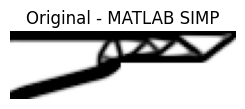

In [ ]:
plt.subplot(1, 2, 1)
plt.title("Original - MATLAB SIMP")
plt.imshow(-true_matrix, cmap='gray') # MATLAB
plt.axis('off')

(np.float64(-0.5), np.float64(99.5), np.float64(29.5), np.float64(-0.5))

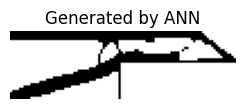

In [ ]:
plt.subplot(1, 2, 2)
plt.title("Generated by ANN")
# Threshold
plt.imshow(-predicted_matrix, cmap='gray')
plt.axis('off')

In [ ]:
plt.show()

**Data Extraction**

In [ ]:
print("\n--- Weight and Bias Extraction ---")
# Hidden_Layer_1 - Example
weights, biases = layer1.get_weights()


--- Weight and Bias Extraction ---


In [ ]:
print(f"Shape Weights - Layer 1: {weights.shape}")
print(f"Shape Bias - Layer 1: {biases.shape}")
print("Values learned (sample):", weights[0][:5])

Shape Weights - Layer 1: (8, 512)
Shape Bias - Layer 1: (512,)
Values learned (sample): [0.0740341  0.08791428 0.02519725 0.07793332 0.08381797]


# **Interface**

In [ ]:
print("Digite os parâmetros da estrutura para previsão:\n")

nelx = float(input("nelx: "))
nely = float(input("nely: "))
volfrac = float(input("volfrac: "))
penal = float(input("penal: "))
rmin = float(input("rmin: "))
F = float(input("F: "))
problem = float(input("problem: "))
geometry = float(input("geometry: "))

user_input = np.array([[nelx, nely, volfrac, penal, rmin, F, problem, geometry]])

# Standardization
user_input_scaled = scaler.transform(user_input)

# Prediction
pred_matrix = model.predict(user_input_scaled)[0]


plt.figure(figsize=(4,4))
plt.imshow(-pred_matrix, cmap='gray')
plt.title("Topologia ótima pela RNA")
plt.axis('off')
plt.show()

Digite os parâmetros da estrutura para previsão:

nelx: 50
nely: 20
volfrac: 0.3
penal: 3
rmin: 1.5
F: 1
problem: 2
geometry: 1


NameError: name 'np' is not defined